<a href="https://colab.research.google.com/github/AnuragRawat04/DefenseProject2025/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/Healthcare+AI+Datasets/Healthcare AI Datasets/Brain_MRI

/content/drive/My Drive/Colab Notebooks/Healthcare+AI+Datasets/Healthcare AI Datasets/Brain_MRI


In [5]:
brain_df=pd.read_csv('data_mask.csv')

In [6]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [7]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [8]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [9]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

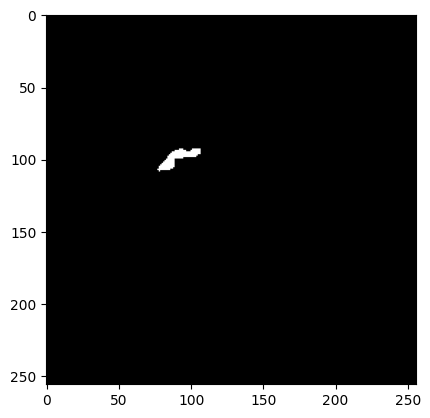

In [10]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

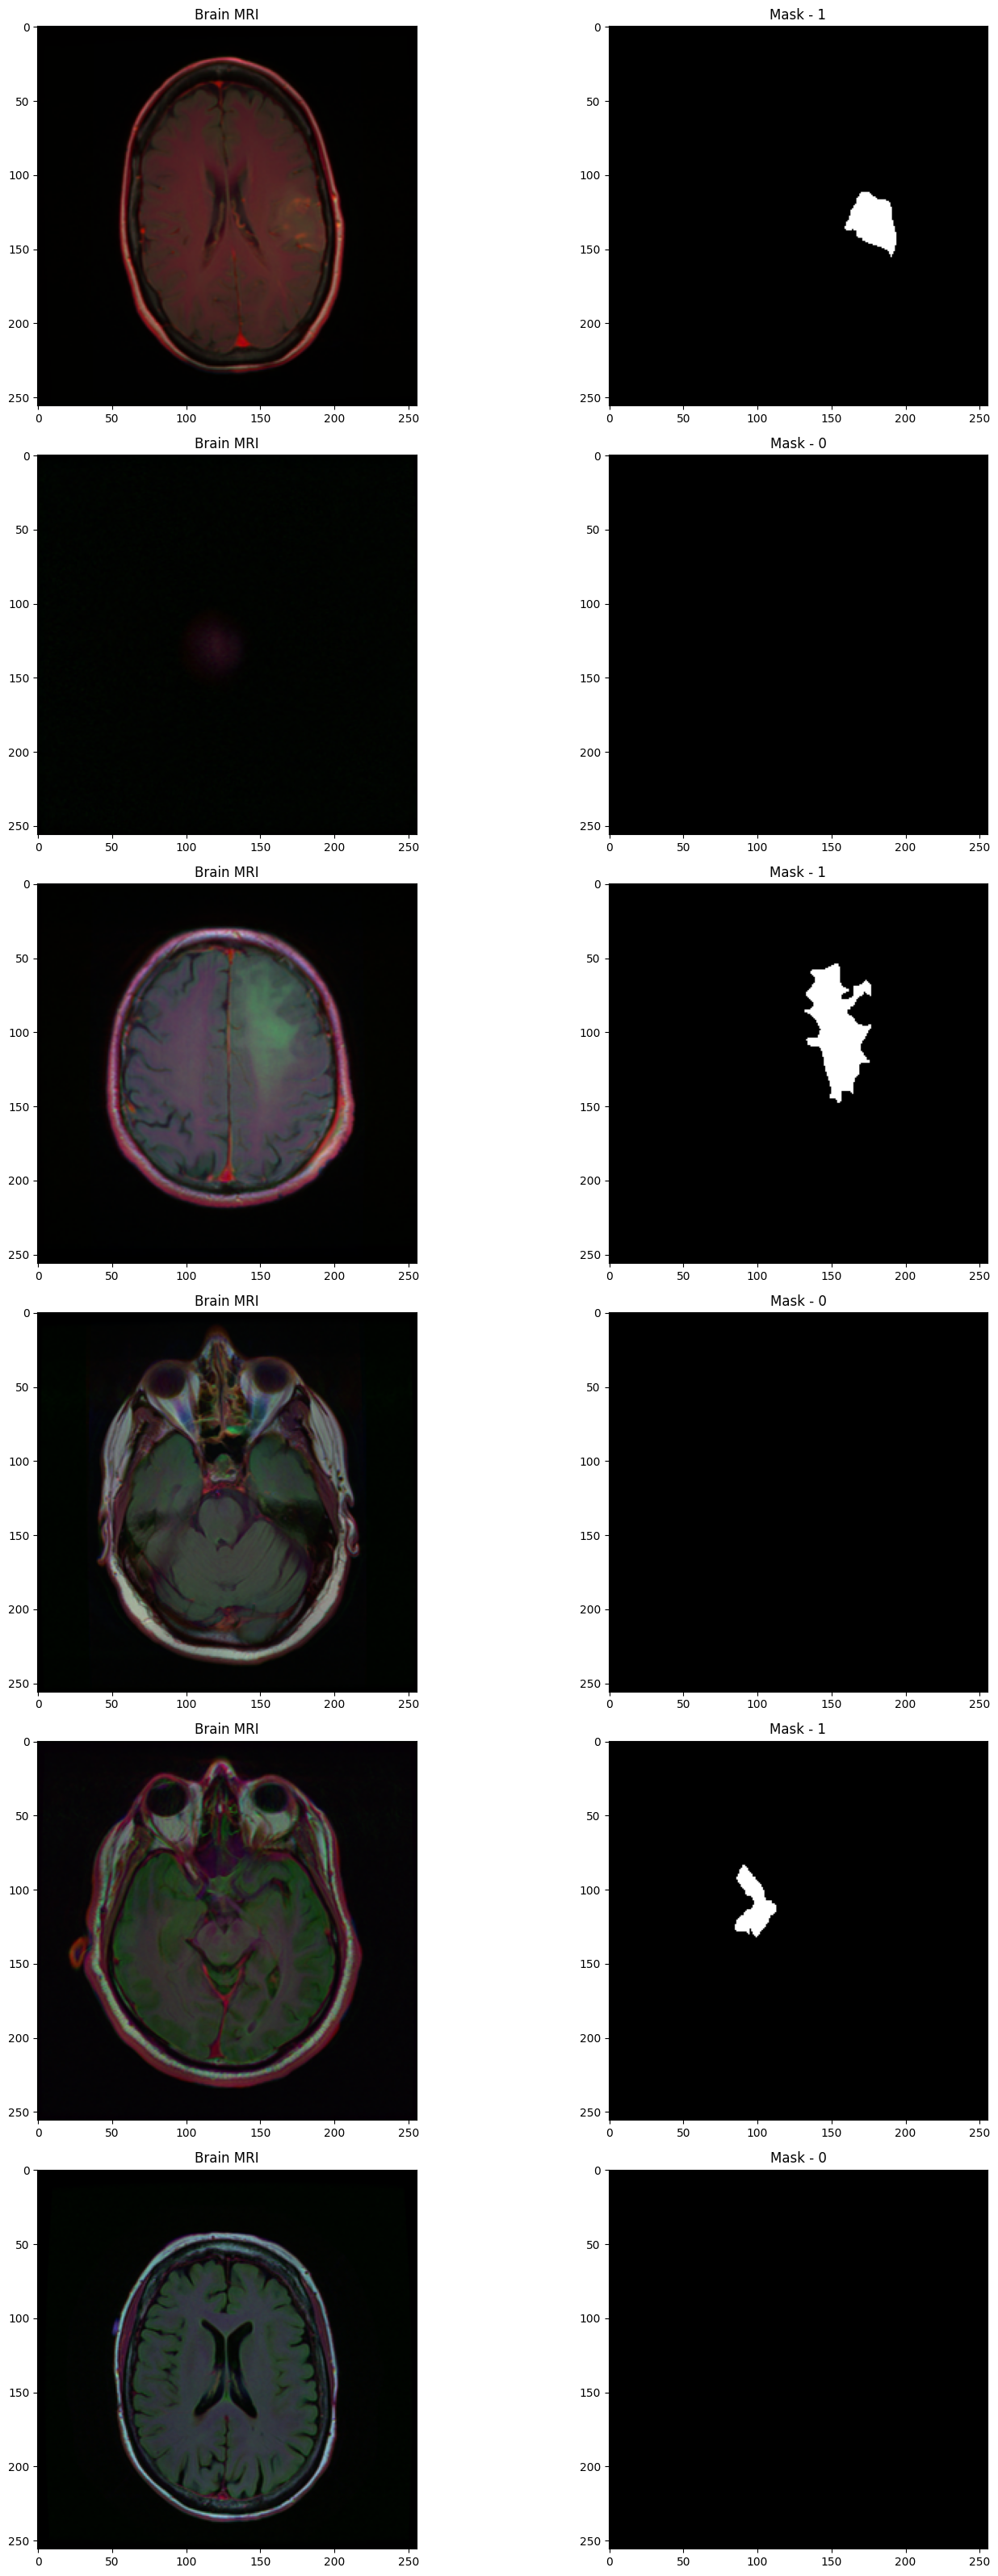

In [11]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

In [12]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [14]:
!pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00


In [15]:
from keras_preprocessing.image import ImageDataGenerator
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [16]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [17]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [52]:
for layer in basemodel.layers:
  layers.trainable = False

In [53]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [54]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,751,426 (98.23 MB)

 Trainable params: 25,698,306 (98.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [56]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="classifier-resnet.weights.h5", verbose=1, save_best_only=True, save_weights_only=True)

In [60]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 5, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9098 - loss: 0.2161
Epoch 1: val_loss did not improve from 0.22999
177/177 ━━━━━━━━━━━━━━━━━━━━ 37s 211ms/step - accuracy: 0.9098 - loss: 0.2161 - val_accuracy: 0.9012 - val_loss: 0.2885
Epoch 2/5
  1/177 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.8750 - loss: 0.2051
Epoch 2: val_loss did not improve from 0.22999
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8750 - loss: 0.2051 - val_accuracy: 0.8931 - val_loss: 0.2886
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9450 - loss: 0.1505
Epoch 3: val_loss did not improve from 0.22999
177/177 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.9450 - loss: 0.1505 - val_accuracy: 0.9032 - val_loss: 0.2554
Epoch 4/5
  1/177 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 1.0000 - loss: 0.0073
Epoch 4: val_loss did not improve from 0.22999
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9093 - val

In [61]:
train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss   = history.history['val_loss'][-1]

# Print simple validation summary
print("Evaluating Custom Model Performance:")
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

Evaluating Custom Model Performance:
Final Training Accuracy: 0.9405
Final Validation Accuracy: 0.9234
Final Training Loss: 0.1652
Final Validation Loss: 0.2248


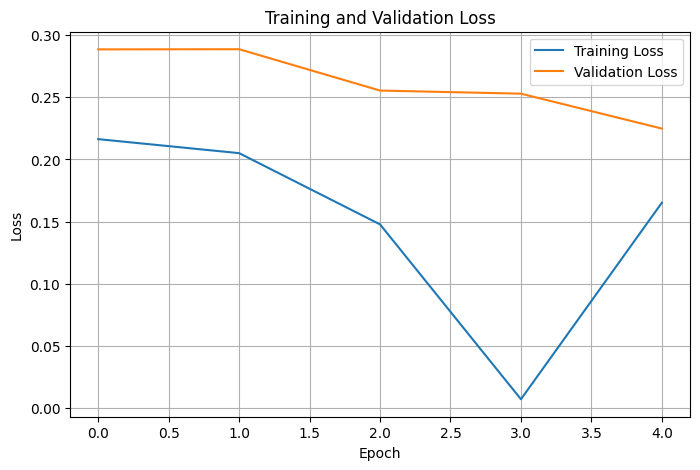

In [62]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step


In [65]:
test_predict.shape

(576, 2)

In [64]:
test_predict

array([[3.7980831e-01, 6.2019163e-01],
       [9.5636743e-01, 4.3632522e-02],
       [9.0548461e-08, 9.9999988e-01],
       ...,
       [9.9180663e-01, 8.1934454e-03],
       [7.4551417e-07, 9.9999928e-01],
       [9.8982155e-01, 1.0178479e-02]], dtype=float32)

In [66]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [67]:
predict

array(['1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0',
       '0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0',
       '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '1',
       '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0',
       '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1

In [68]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [69]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9357638888888888

<Axes: >

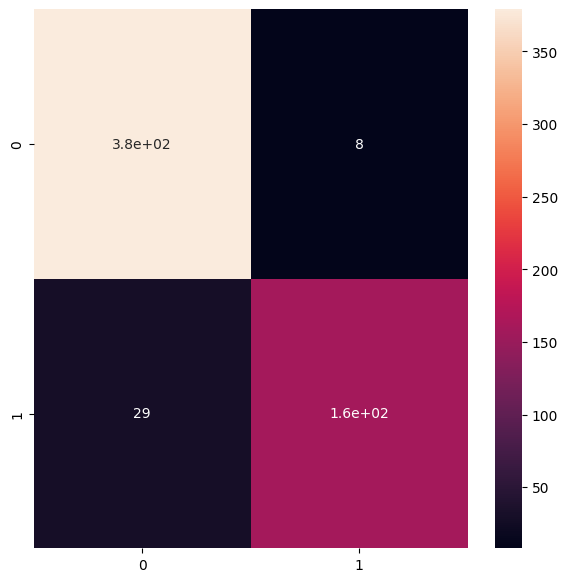

In [70]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [71]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       387
           1       0.95      0.85      0.90       189

   micro avg       0.94      0.94      0.94       576
   macro avg       0.94      0.91      0.92       576
weighted avg       0.94      0.94      0.93       576



In [72]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [73]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [74]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [106]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [107]:
def resblock(X, f):

  X_copy = X

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [78]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [108]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [109]:
model_seg.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │        544 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_16[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │        544 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 128, 128,  │          0 │ add_8[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │      2,112 │ max_pooling2d_5[

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

In [110]:
from utilities import focal_tversky, tversky_loss, tversky
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [111]:
def tversky(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')  # Cast to float32 to fix dtype mismatch
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + 0.7 * false_neg + 0.3 * false_pos + smooth)

In [112]:
adam = tf.keras.optimizers.Adam(learning_rate=0.5, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

In [114]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.h5", verbose=1, save_best_only=True)

In [115]:
history = model_seg.fit(
    training_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpointer, earlystopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.6986 - tversky: 0.3719

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.00000, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 274ms/step - loss: 0.6967 - tversky: 0.3741 - val_loss: 1.0000 - val_tversky: 4.7999e-05
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.3782 - tversky: 0.7241
Epoch 2: val_loss improved from 1.00000 to 0.72589, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - loss: 0.3784 - tversky: 0.7240 - val_loss: 0.7259 - val_tversky: 0.3468
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.3708 - tversky: 0.7310
Epoch 3: val_loss improved from 0.72589 to 0.54661, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 237ms/step - loss: 0.3709 - tversky: 0.7309 - val_loss: 0.5466 - val_tversky: 0.5515
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.3483 - tversky: 0.7529
Epoch 4: val_loss improved from 0.54661 to 0.37058, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - loss: 0.3481 - tversky: 0.7530 - val_loss: 0.3706 - val_tversky: 0.7327
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.3005 - tversky: 0.7963
Epoch 5: val_loss did not improve from 0.37058
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - loss: 0.3005 - tversky: 0.7963 - val_loss: 0.3775 - val_tversky: 0.7254
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.2823 - tversky: 0.8134
Epoch 6: val_loss improved from 0.37058 to 0.36831, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - loss: 0.2820 - tversky: 0.8136 - val_loss: 0.3683 - val_tversky: 0.7314
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.2512 - tversky: 0.8403
Epoch 7: val_loss improved from 0.36831 to 0.36398, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 232ms/step - loss: 0.2515 - tversky: 0.8400 - val_loss: 0.3640 - val_tversky: 0.7377
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.2452 - tversky: 0.8450
Epoch 8: val_loss improved from 0.36398 to 0.28360, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - loss: 0.2450 - tversky: 0.8451 - val_loss: 0.2836 - val_tversky: 0.8122
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.2300 - tversky: 0.8582
Epoch 9: val_loss did not improve from 0.28360
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - loss: 0.2301 - tversky: 0.8582 - val_loss: 0.3198 - val_tversky: 0.7794
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.2293 - tversky: 0.8584
Epoch 10: val_loss did not improve from 0.28360
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - loss: 0.2294 - tversky: 0.8583 - val_loss: 0.3403 - val_tversky: 0.7607
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.2333 - tversky: 0.8550
Epoch 11: val_loss did not improve from 0.28360
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step - loss: 0.2332 - tversky: 0.8551 - val_loss: 0.2837 - val_tversky: 0.8085
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.2148 - tversky: 0.8703
Epoch 12: val_loss improved from 0.28360 to 0.2627

72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - loss: 0.2147 - tversky: 0.8705 - val_loss: 0.2628 - val_tversky: 0.8290
Epoch 13/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.1940 - tversky: 0.8870
Epoch 13: val_loss improved from 0.26279 to 0.20325, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - loss: 0.1939 - tversky: 0.8870 - val_loss: 0.2033 - val_tversky: 0.8799
Epoch 14/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.1836 - tversky: 0.8947
Epoch 14: val_loss did not improve from 0.20325
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - loss: 0.1837 - tversky: 0.8947 - val_loss: 0.2117 - val_tversky: 0.8727
Epoch 15/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.1705 - tversky: 0.9050
Epoch 15: val_loss did not improve from 0.20325
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - loss: 0.1705 - tversky: 0.9050 - val_loss: 0.2147 - val_tversky: 0.8698
Epoch 16/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.1660 - tversky: 0.9082
Epoch 16: val_loss improved from 0.20325 to 0.15766, saving model to ResUNet-weights.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - loss: 0.1659 - tversky: 0.9083 - val_loss: 0.1577 - val_tversky: 0.9144
Epoch 17/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.1537 - tversky: 0.9172
Epoch 17: val_loss did not improve from 0.15766
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - loss: 0.1538 - tversky: 0.9172 - val_loss: 0.1628 - val_tversky: 0.9110
Epoch 18/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.1516 - tversky: 0.9184
Epoch 18: val_loss did not improve from 0.15766
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - loss: 0.1516 - tversky: 0.9184 - val_loss: 0.1832 - val_tversky: 0.8959
Epoch 19/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.1520 - tversky: 0.9184
Epoch 19: val_loss did not improve from 0.15766
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - loss: 0.1522 - tversky: 0.9182 - val_loss: 0.2806 - val_tversky: 0.8130
Epoch 20/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.1864 - tversky: 0.8926
Epoch 20: val_loss did not improve from 0.15766


In [116]:
from utilities import prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

In [117]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_22...   
1    TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_40...   
2    TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_21...   
3    TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_18...   
4    TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_3.tif   
..                                                 ...   
585  TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_8.tif   
586  TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_17...   
587  TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_28...   
588  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_18...   
589  TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_33...   

                                        predicted_mask  has_mask  
0    [[[[6.402381e-07], [8.129603e-08], [4.517605e-...         1  
1                                              No mask         0  
2    [[[[6.322785e-07], [7.808506e-08], [4.26922e-0...         1  
3                                              No mask         0  
4                                              No mask         0  
..                                                 ...       ...  
585                                            No mask         0  
586  [[[[4.5958248e-07], [6.125507e-08], [3.989983e...         1  
587                                            No mask         0  
588  [[[[5.369856e-07], [1.6670427e-07], [7.4812584...         1  
589                                            No mask         0  

[590 rows x 3 columns]

In [118]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_22...   
1  TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_40...   
2  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_21...   
3  TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_18...   
4  TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_3.tif   

                                           mask_path mask  \
0  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_22...    1   
1  TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_40...    0   
2  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_21...    1   
3  TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_18...    1   
4  TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_3_...    0   

                                      predicted_mask  has_mask  
0  [[[[6.402381e-07], [8.129603e-08], [4.517605e-...         1  
1                                            No mask         0  
2  [[[[6.322785e-07], [7.808506e-08], [4.26922e-0...         1  
3                                            No mask         0  
4                                            No mask         0

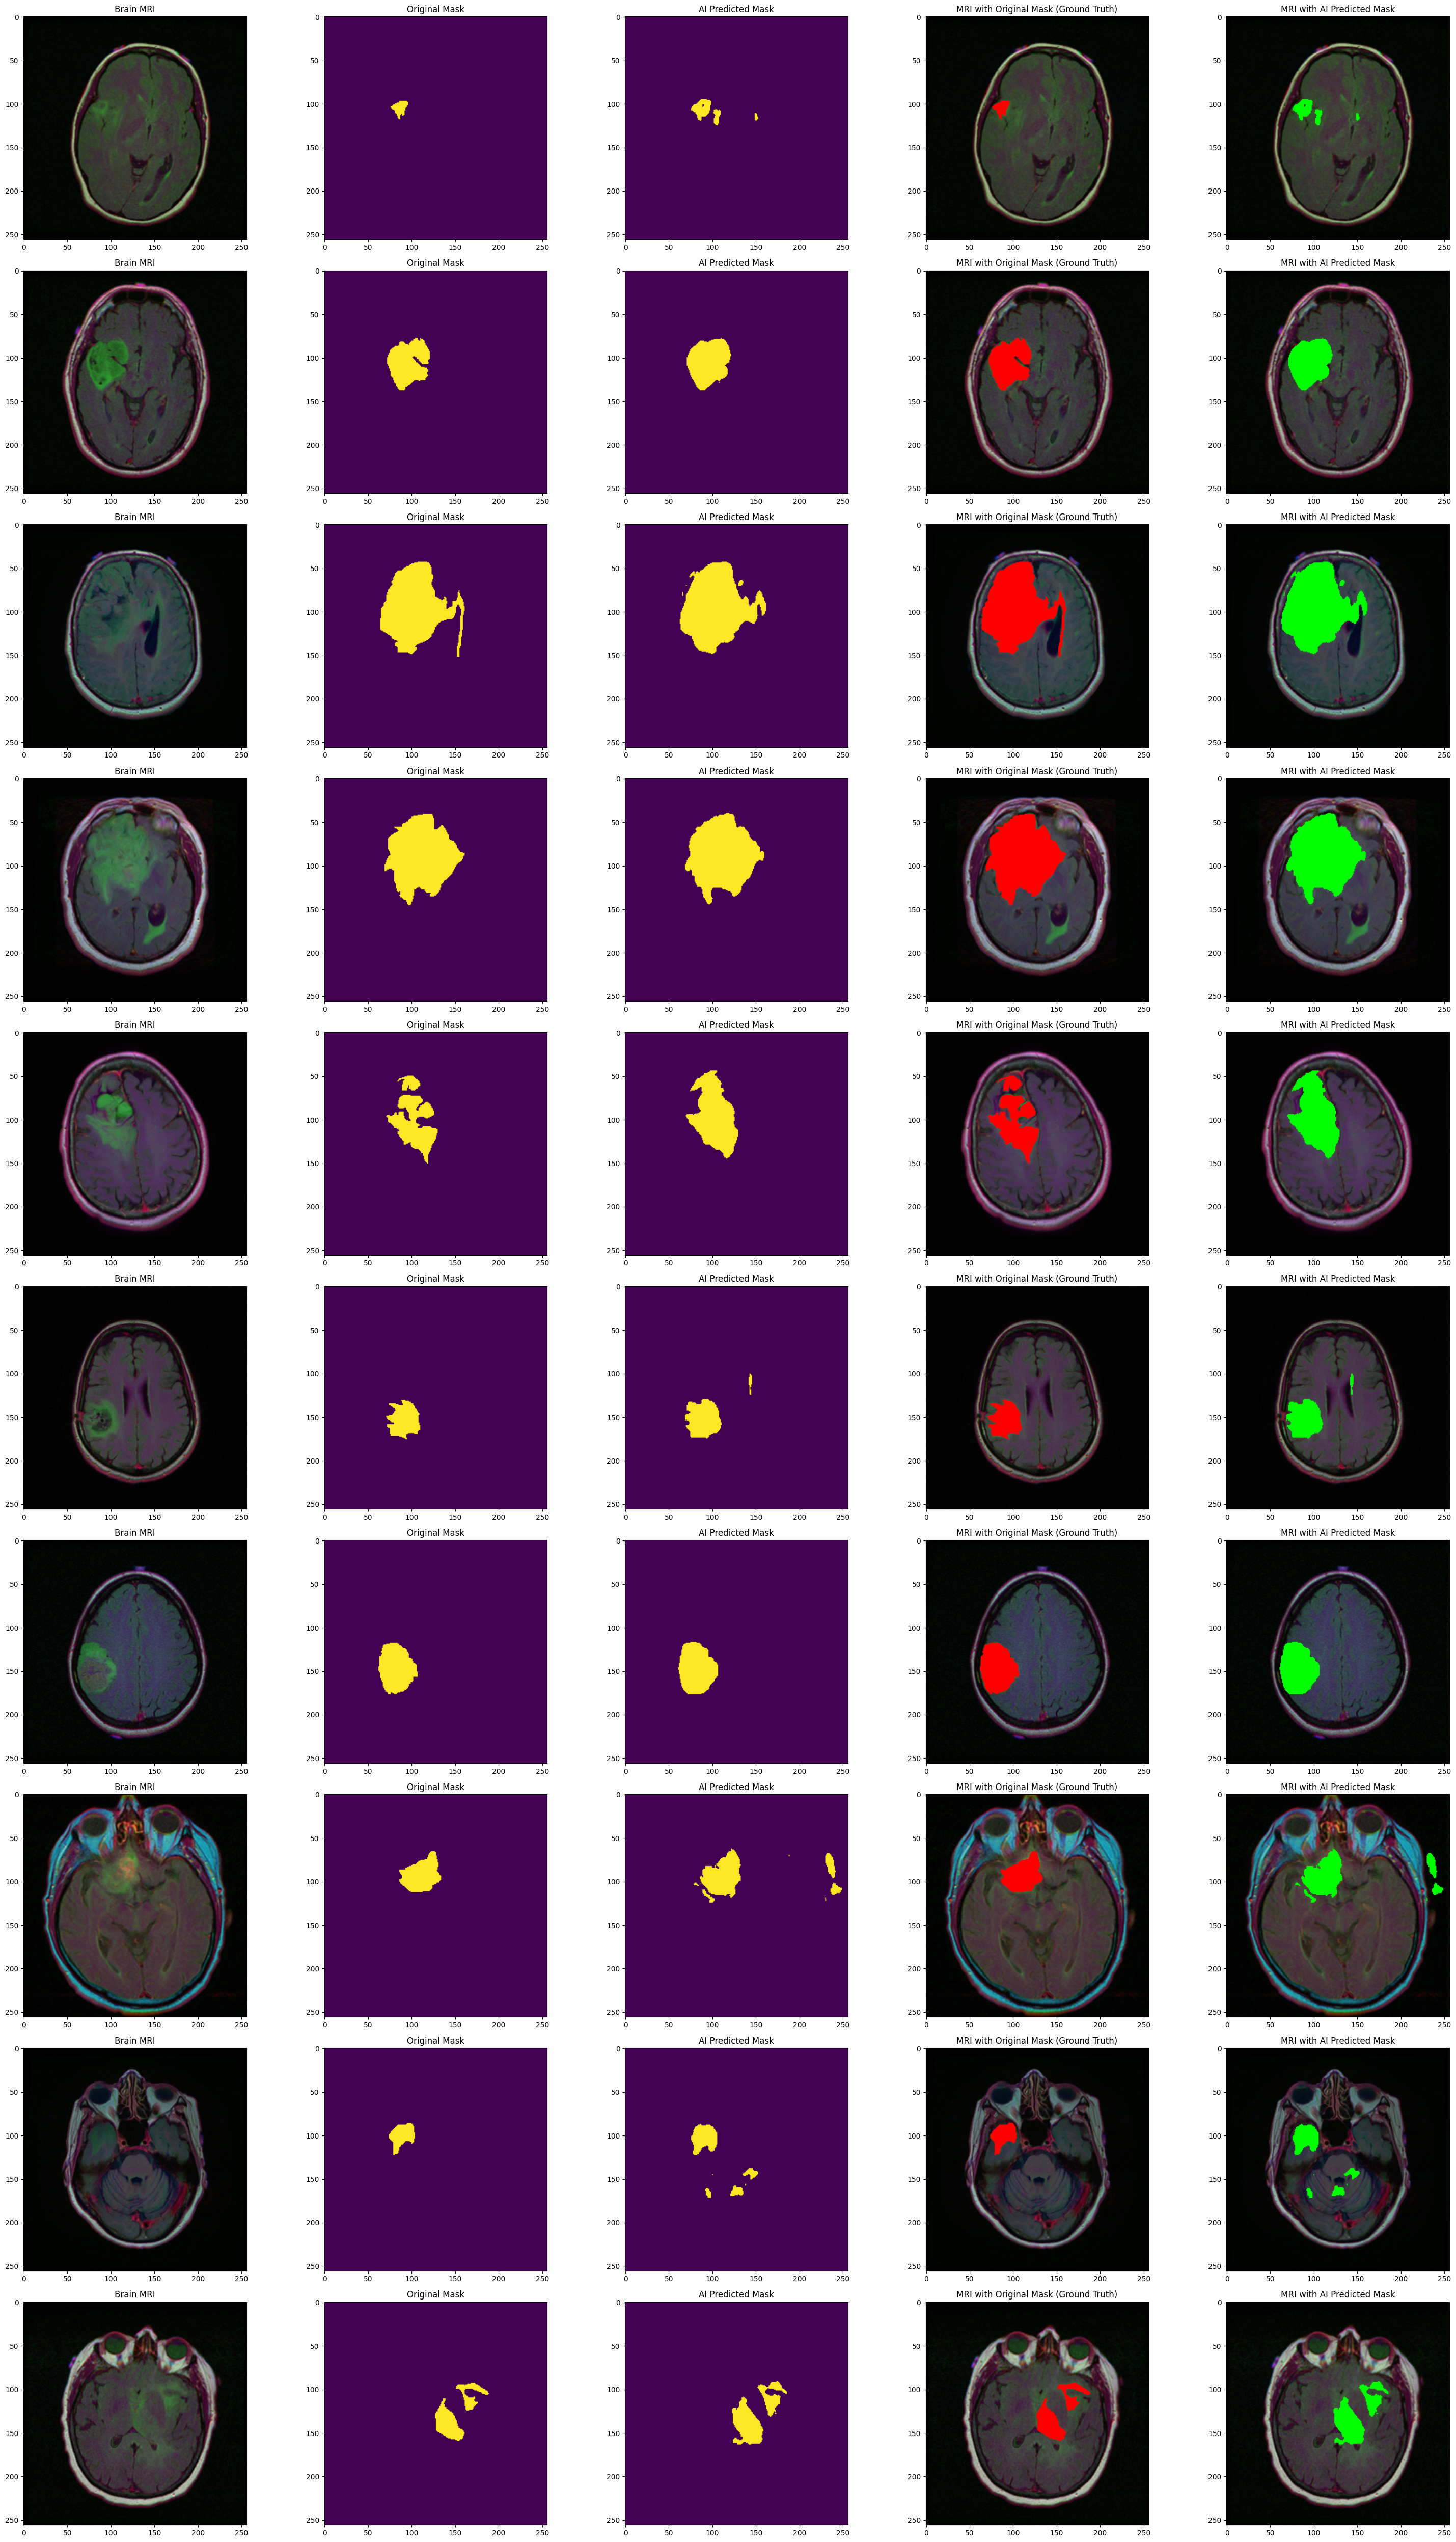

In [119]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)

    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

In [ ]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)